Loading samples: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


Subtitle text:
 barks τhey're waiting for you
no it's just a bunch of cops talking
when l walk through the door they all stop what they were talking about and they looked at me
laughs τhat's hard man
τhat's a fuckin' hard situation
τhe german shepherd starts barking
barks ηe's barking at me
l mean it's obvious he's barking at me
barks εvery nerve ending all my senses blood in my veins everything l have is screaming


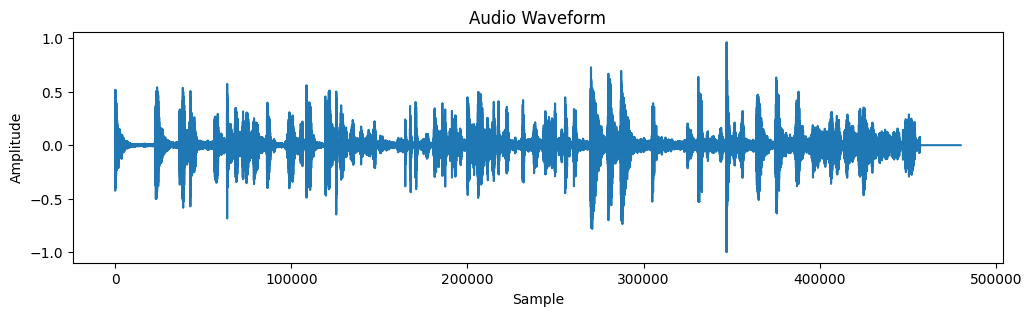

In [1]:
import matplotlib.pyplot as plt
import os
import random
import torchaudio

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import List, Tuple


class MovieSubDataset(Dataset):
    def __init__(self, samples: List[Tuple[str, str]], resample_rate: int = 16_000, show_progress: bool =True):
        self.resample_rate = resample_rate
        self.data = []

        iterator = tqdm(samples, desc="Loading samples") if show_progress else samples

        for wav_path, txt_path in iterator:
            waveform, sample_rate = torchaudio.load(wav_path)
            with open(txt_path, "r", encoding="utf-8") as f:
                subtitle_text = f.read()

            # convert to mono (if stereo) - downmixing
            if waveform.size(0) > 1:
                waveform = waveform.mean(dim=0, keepdim=True)

            # resample to resample_rate
            if sample_rate != self.resample_rate:
                resampler = torchaudio.transforms.Resample(
                    orig_freq=sample_rate, new_freq=self.resample_rate
                )
                waveform = resampler(waveform)
                
            # normalize: scale waveform to [-1, 1] range
            waveform = waveform / waveform.abs().max()
            
            self.data.append((waveform, sample_rate, subtitle_text))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def fetch_samples(root_dir: str) -> List[Tuple[str, str]]:
    all_samples = []

    for movie_name in os.listdir(root_dir):
        movie_path = os.path.join(root_dir, movie_name)
        if not os.path.isdir(movie_path):
            continue

        for fname in os.listdir(movie_path):
            if fname.endswith(".wav"):
                base = os.path.splitext(fname)[0]

                wav_path = os.path.join(movie_path, f"{base}.wav")
                txt_path = os.path.join(movie_path, f"{base}.txt")

                if os.path.exists(wav_path) and os.path.exists(txt_path):
                    all_samples.append((wav_path, txt_path))

    return all_samples


def load_movie_subs(root_dir: str, batch_size: int = 64) -> Tuple[DataLoader, DataLoader, DataLoader]:
    all_samples = fetch_samples(os.path.join(root_dir, "train"))
    test_samples = fetch_samples(os.path.join(root_dir, "test"))

    # shuffle and split
    random.seed(42)
    random.shuffle(all_samples)

    train_data, val_data = train_test_split(all_samples, test_size=0.3, random_state=42)

    # create DataLoaders
    train_loader = DataLoader(MovieSubDataset(train_data), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(MovieSubDataset(val_data), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(MovieSubDataset(test_samples), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


def main():
    train_loader, validation_loader, test_loader = load_movie_subs("/kaggle/input/movie2sub-dataset/dataset")

    batch = next(iter(train_loader))
    waveform, sample_rate, subtitle = batch[0][0], batch[1][0], batch[2][0]

    print("Subtitle text:\n", subtitle)

    plt.figure(figsize=(12, 3))
    plt.plot(waveform.squeeze().numpy())
    plt.title("Audio Waveform")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()
    

if __name__ == "__main__":
    main()